# Supplementary Document 3
## Author: Revanth Mamidala
**Explanation:** 
The below script takes the csv files generated in the supplementary documents 1 & 2 as input and perform 
data analysis. 

## 1. Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

## 2. Define Directory and Load Data

In [2]:
# Define the directory containing the data files
data_dir = r"G:\My Drive\TermPaper\Data_Aggregation_GEE\Merged Data"

# Load observed and gridded datasets
files = {
    "Observed": "observed_precip_data.csv",
    "CHIRPS": "CHIRPS_2006_2024.csv",
    "ERA5": "ERA5_daily_2006_2024.csv",
    "GLDAS": "GLDAS_2006_2024.csv",
    "GPM": "GPM_2006_2024.csv",
    "GSMAP": "GSMAP_2006_2024.csv",
    "PERSIANN": "PERSIANN_2006_2020.csv",
    "PRISM": "PRISM_2006_2024.csv",
    "CHIRPS_1": "CHIRPS_1_2006_2024.csv"
}

# Load datasets into a dictionary
dataframes = {name: pd.read_csv(os.path.join(data_dir, file)) for name, file in files.items()}

## 3. Preprocess Data

In [3]:
# Standardize date formats and align datasets temporally with Observed
for name, df in dataframes.items():
    if 'Date' in df.columns:
        if name == "CHIRPS_1":
            # Parse CHIRPS with assumed DD-MM-YYYY format
            df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y', errors='coerce')
        else:
            # Parse other datasets assuming YYYY-MM-DD
            df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

        # Check for unparsed dates
        unparsed_dates = df[df['Date'].isna()]
        if not unparsed_dates.empty:
            print(f"Unparsed dates in {name}:")
            print(unparsed_dates.head())  # Print the first few rows with unparsed dates
            
            # Inspect unparsed rows
            print(f"Sample problematic dates in {name}:")
            print(df.loc[df['Date'].isna(), 'Date'].head())
            
            # Optionally drop rows with NaT or fill with a placeholder
            print(f"Removing rows with invalid dates from {name}.")
            df = df.dropna(subset=['Date'])

        # Update dataframe after cleaning
        dataframes[name] = df

# Align all datasets to observed date range
observed_dates = pd.to_datetime(dataframes["Observed"]["Date"])
for name, df in dataframes.items():
    if 'Date' in df.columns:
        dataframes[name] = df[df["Date"].isin(observed_dates)].reset_index(drop=True)


Unparsed dates in CHIRPS_1:
  Date       DVP       MJQ       MWM       OTG       AXA       BNW       CAV  \
0  NaT  0.000000  0.000000  0.908342  0.000000  2.761978  1.974056  2.228651   
1  NaT  2.746415  3.149903  1.816684  2.856053  1.380989  1.974056  2.228651   
2  NaT  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3  NaT  0.000000  0.000000  0.908342  0.000000  0.000000  0.000000  0.000000   
4  NaT  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

   CIN       CNC  ...       EST       FOD       I75       IKV       OOA  \
0  0.0  3.698311  ...  1.335371  0.000000  3.946273  0.000000  0.000000   
1  0.0  3.698311  ...  1.335371  2.699101  3.946273  4.140499  3.752781   
2  0.0  0.000000  ...  0.000000  0.000000  0.000000  0.000000  0.000000   
3  0.0  0.000000  ...  0.000000  0.000000  0.000000  0.000000  0.000000   
4  0.0  0.000000  ...  0.000000  0.000000  0.000000  0.000000  3.752781   

        OTM  OXV  PEA       PRO       SL

## 4. Define Metrics Function

In [4]:
def calculate_metrics(observed, simulated):
    """Calculate evaluation metrics between observed and simulated data."""
    rmse = np.sqrt(mean_squared_error(observed, simulated))
    mae = mean_absolute_error(observed, simulated)
    r2 = np.corrcoef(observed, simulated)[0, 1]
    relative_bias = 100 * (simulated.sum() - observed.sum()) / observed.sum()
    
    return {"RMSE": rmse, "MAE": mae, "R2": r2, "rBIAS (%)": relative_bias}


## 5. Perform Metrics Calculation

In [5]:
# Perform metrics calculation for each station and gridded dataset
results = {}

# Loop through each gridded dataset
for name, df in dataframes.items():
    if name == "Observed":
        continue  # Skip the observed dataset

    station_metrics = {}
    for station in dataframes["Observed"].columns[1:]:  # Skip the 'Date' column
        if station in df.columns:
            # Merge observed and simulated on the 'Date' column
            merged = pd.merge(
                dataframes["Observed"][["Date", station]].dropna(),
                df[["Date", station]].dropna(),
                on="Date",
                suffixes=("_obs", "_sim")
            )
            if not merged.empty:
                observed = merged[f"{station}_obs"]
                simulated = merged[f"{station}_sim"]
                # Calculate metrics
                station_metrics[station] = calculate_metrics(observed, simulated)
    results[name] = station_metrics


## 6. Save Metrics to CSV

In [6]:
# Compile results into a DataFrame
metrics_df = pd.DataFrame.from_dict({(dataset, station): metrics 
                                     for dataset, stations in results.items() 
                                     for station, metrics in stations.items()},
                                    orient='index')

# Reset index and rename columns for clarity
metrics_df.index = pd.MultiIndex.from_tuples(metrics_df.index, names=["Dataset", "Station"])
metrics_df.reset_index(inplace=True)

print(metrics_df)
# Save the metrics to a CSV file
output_file = os.path.join(data_dir, "rainfall_comparison_metrics.csv")
metrics_df.to_csv(output_file, index=False)
print(f"Metrics saved to {output_file}")



    Dataset Station       RMSE       MAE        R2  rBIAS (%)
0    CHIRPS     AXA   7.547333  3.391320  0.511944  12.030169
1    CHIRPS     BNW   7.525971  3.403515  0.620363  15.556067
2    CHIRPS     CAV   7.374535  3.325825  0.548069  17.764706
3    CHIRPS     CIN   7.344335  3.388931  0.563270  19.237042
4    CHIRPS     CNC   7.901622  3.684117  0.584309  13.660257
..      ...     ...        ...       ...       ...        ...
149   PRISM     MJQ  32.489424  4.472757  0.156136 -29.218526
150   PRISM     MWM   7.667974  2.703977  0.548256  78.241297
151   PRISM     OTG   8.721096  3.038646  0.233096  11.424245
152   PRISM     I75   8.353417  3.673641  0.634316  13.712596
153   PRISM     PRO   6.669875  2.903525  0.709157  39.129231

[154 rows x 6 columns]
Metrics saved to G:\My Drive\TermPaper\Data_Aggregation_GEE\Merged Data\rainfall_comparison_metrics.csv


## Data Line Plot

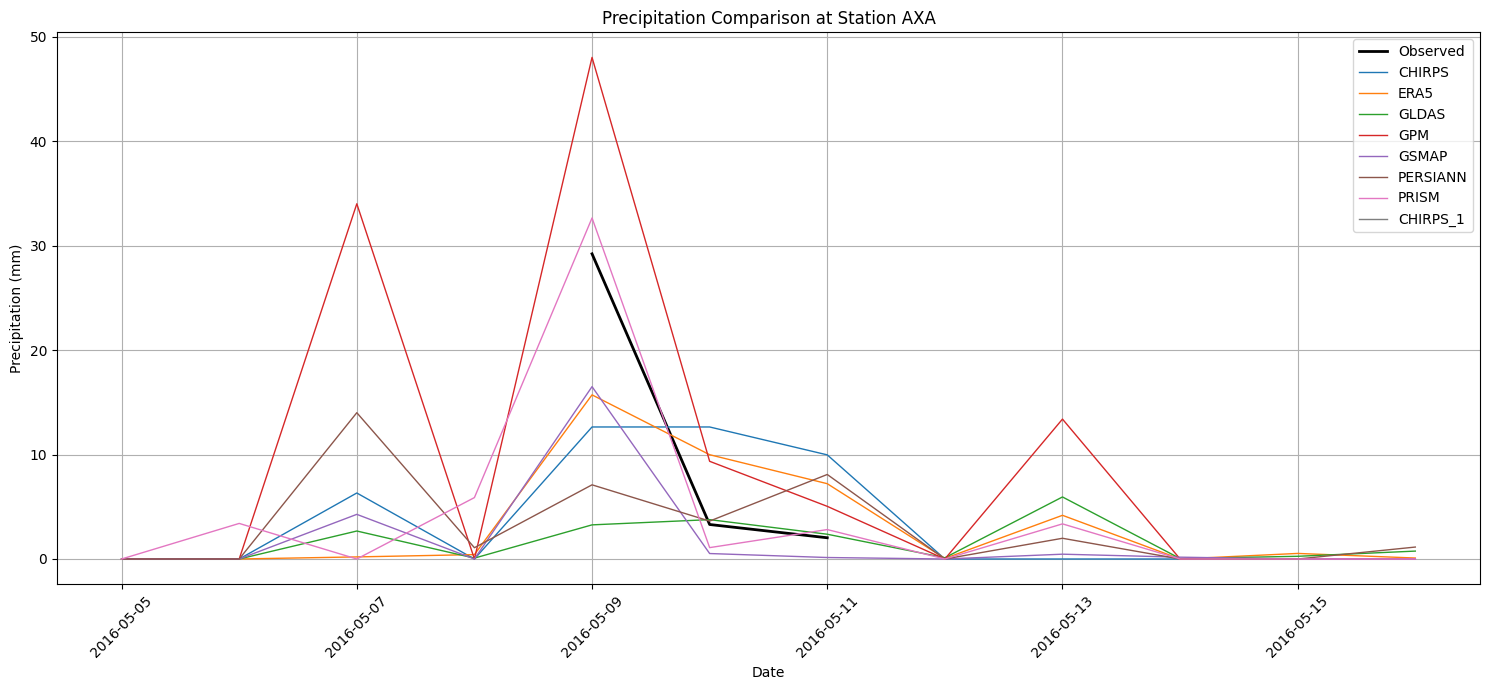

In [19]:
import matplotlib.pyplot as plt

# Define date range
date1 = pd.to_datetime("2016-05-05")
date2 = pd.to_datetime("2016-05-16")

plt.figure(figsize=(15, 7))

# Plot observed data for AXA
observed_df = dataframes["Observed"]
observed_filtered = observed_df[(observed_df["Date"].between(date1, date2))]
plt.plot(observed_filtered["Date"], observed_filtered["AXA"], label="Observed", linewidth=2, linestyle='-', color='black')

# Plot data from each gridded dataset for AXA
for name, df in dataframes.items():
    if name != "Observed" and "AXA" in df.columns:
        df_filtered = df[df["Date"].between(date1, date2)]
        plt.plot(df_filtered["Date"], df_filtered["AXA"], label=name, linewidth=1)

# Add labels, title, and legend
plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.title("Precipitation Comparison at Station AXA")
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


## 7. RMSE Line Plot

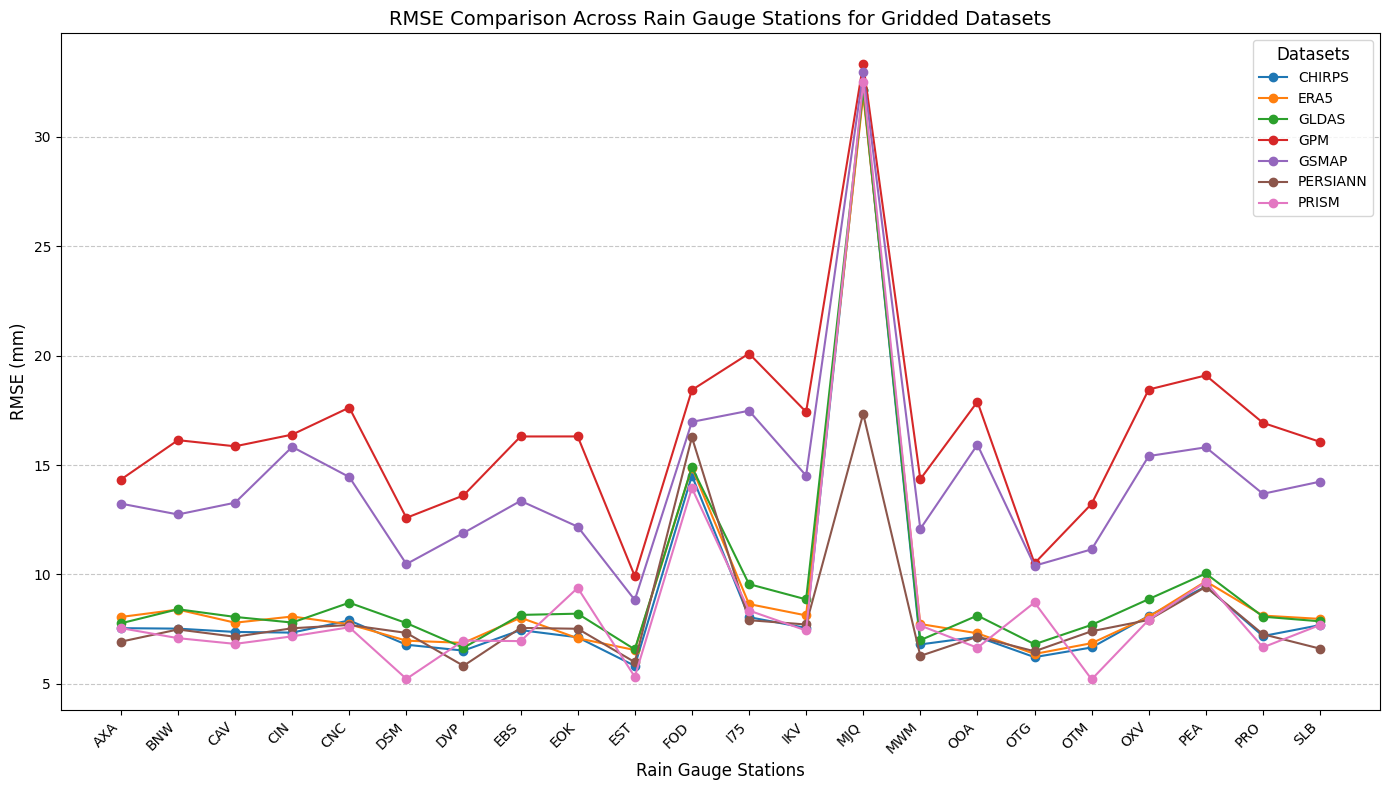

In [7]:
import matplotlib.pyplot as plt

# Extract RMSE values for plotting
rmse_data = metrics_df.pivot(index="Station", columns="Dataset", values="RMSE")

# Plot RMSE across stations
plt.figure(figsize=(14, 8))
for dataset in rmse_data.columns:
    plt.plot(rmse_data.index, rmse_data[dataset], label=dataset, marker='o')

# Customize the plot
plt.xlabel("Rain Gauge Stations", fontsize=12)
plt.ylabel("RMSE (mm)", fontsize=12)
plt.title("RMSE Comparison Across Rain Gauge Stations for Gridded Datasets", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Datasets", fontsize=10, title_fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


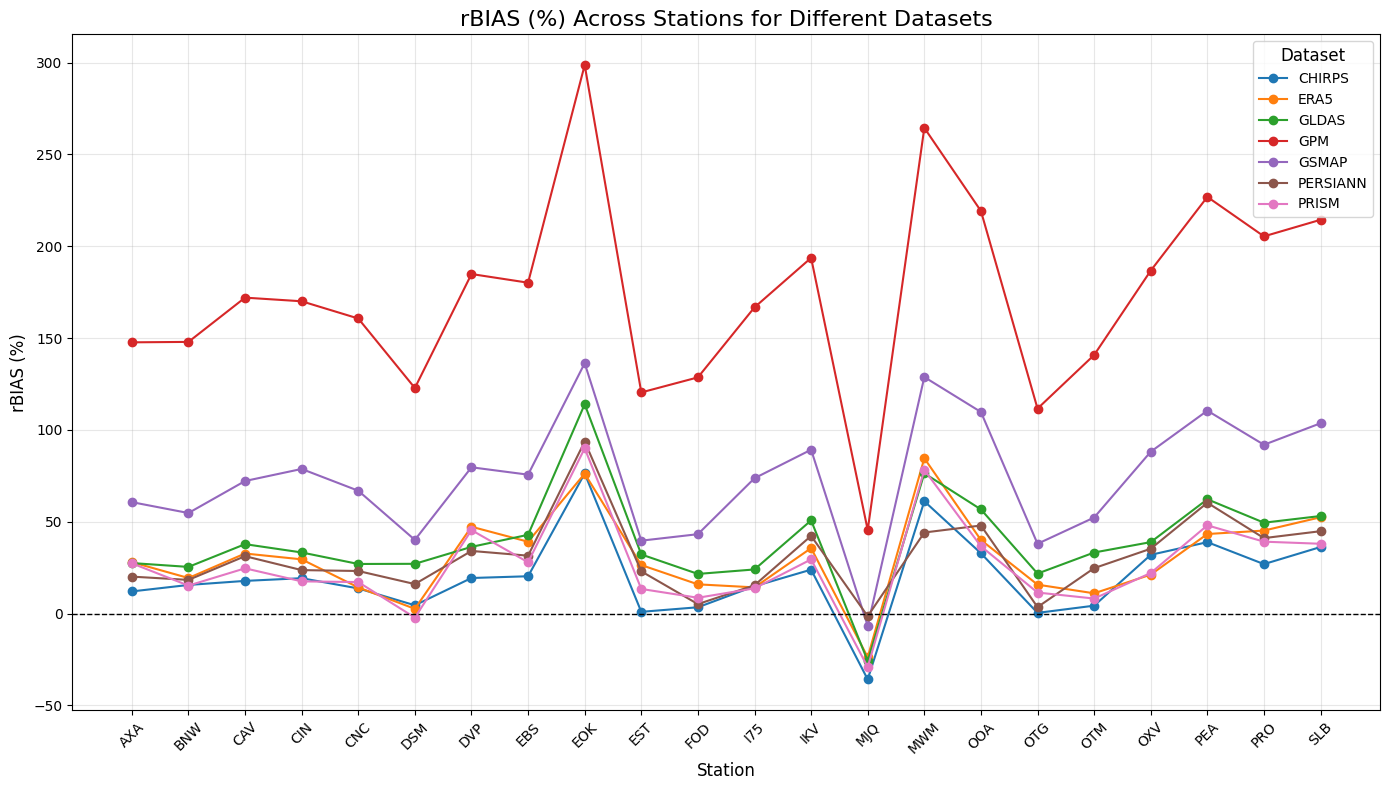

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the DataFrame for rBIAS (%)
rbias_data = metrics_df.pivot(index="Station", columns="Dataset", values="rBIAS (%)")

# Create the line graph
plt.figure(figsize=(14, 8))
for dataset in rbias_data.columns:
    plt.plot(
        rbias_data.index,  # X-axis: Stations
        rbias_data[dataset],  # Y-axis: rBIAS (%) values for each dataset
        marker="o",  # Add markers at data points
        label=dataset  # Add legend for the dataset
    )

# Customize the plot
plt.axhline(0, color="black", linestyle="--", linewidth=1)  # Add a horizontal line at 0%
plt.title("rBIAS (%) Across Stations for Different Datasets", fontsize=16)
plt.xlabel("Station", fontsize=12)
plt.ylabel("rBIAS (%)", fontsize=12)
plt.xticks(rotation=45)  # Rotate station names for better readability
plt.grid(alpha=0.3)  # Add a light grid for readability
plt.legend(title="Dataset", fontsize=10, title_fontsize=12, loc="best")
plt.tight_layout()

# Show the plot
plt.show()


## 8. Scatterplots for Observed vs. Predicted Values

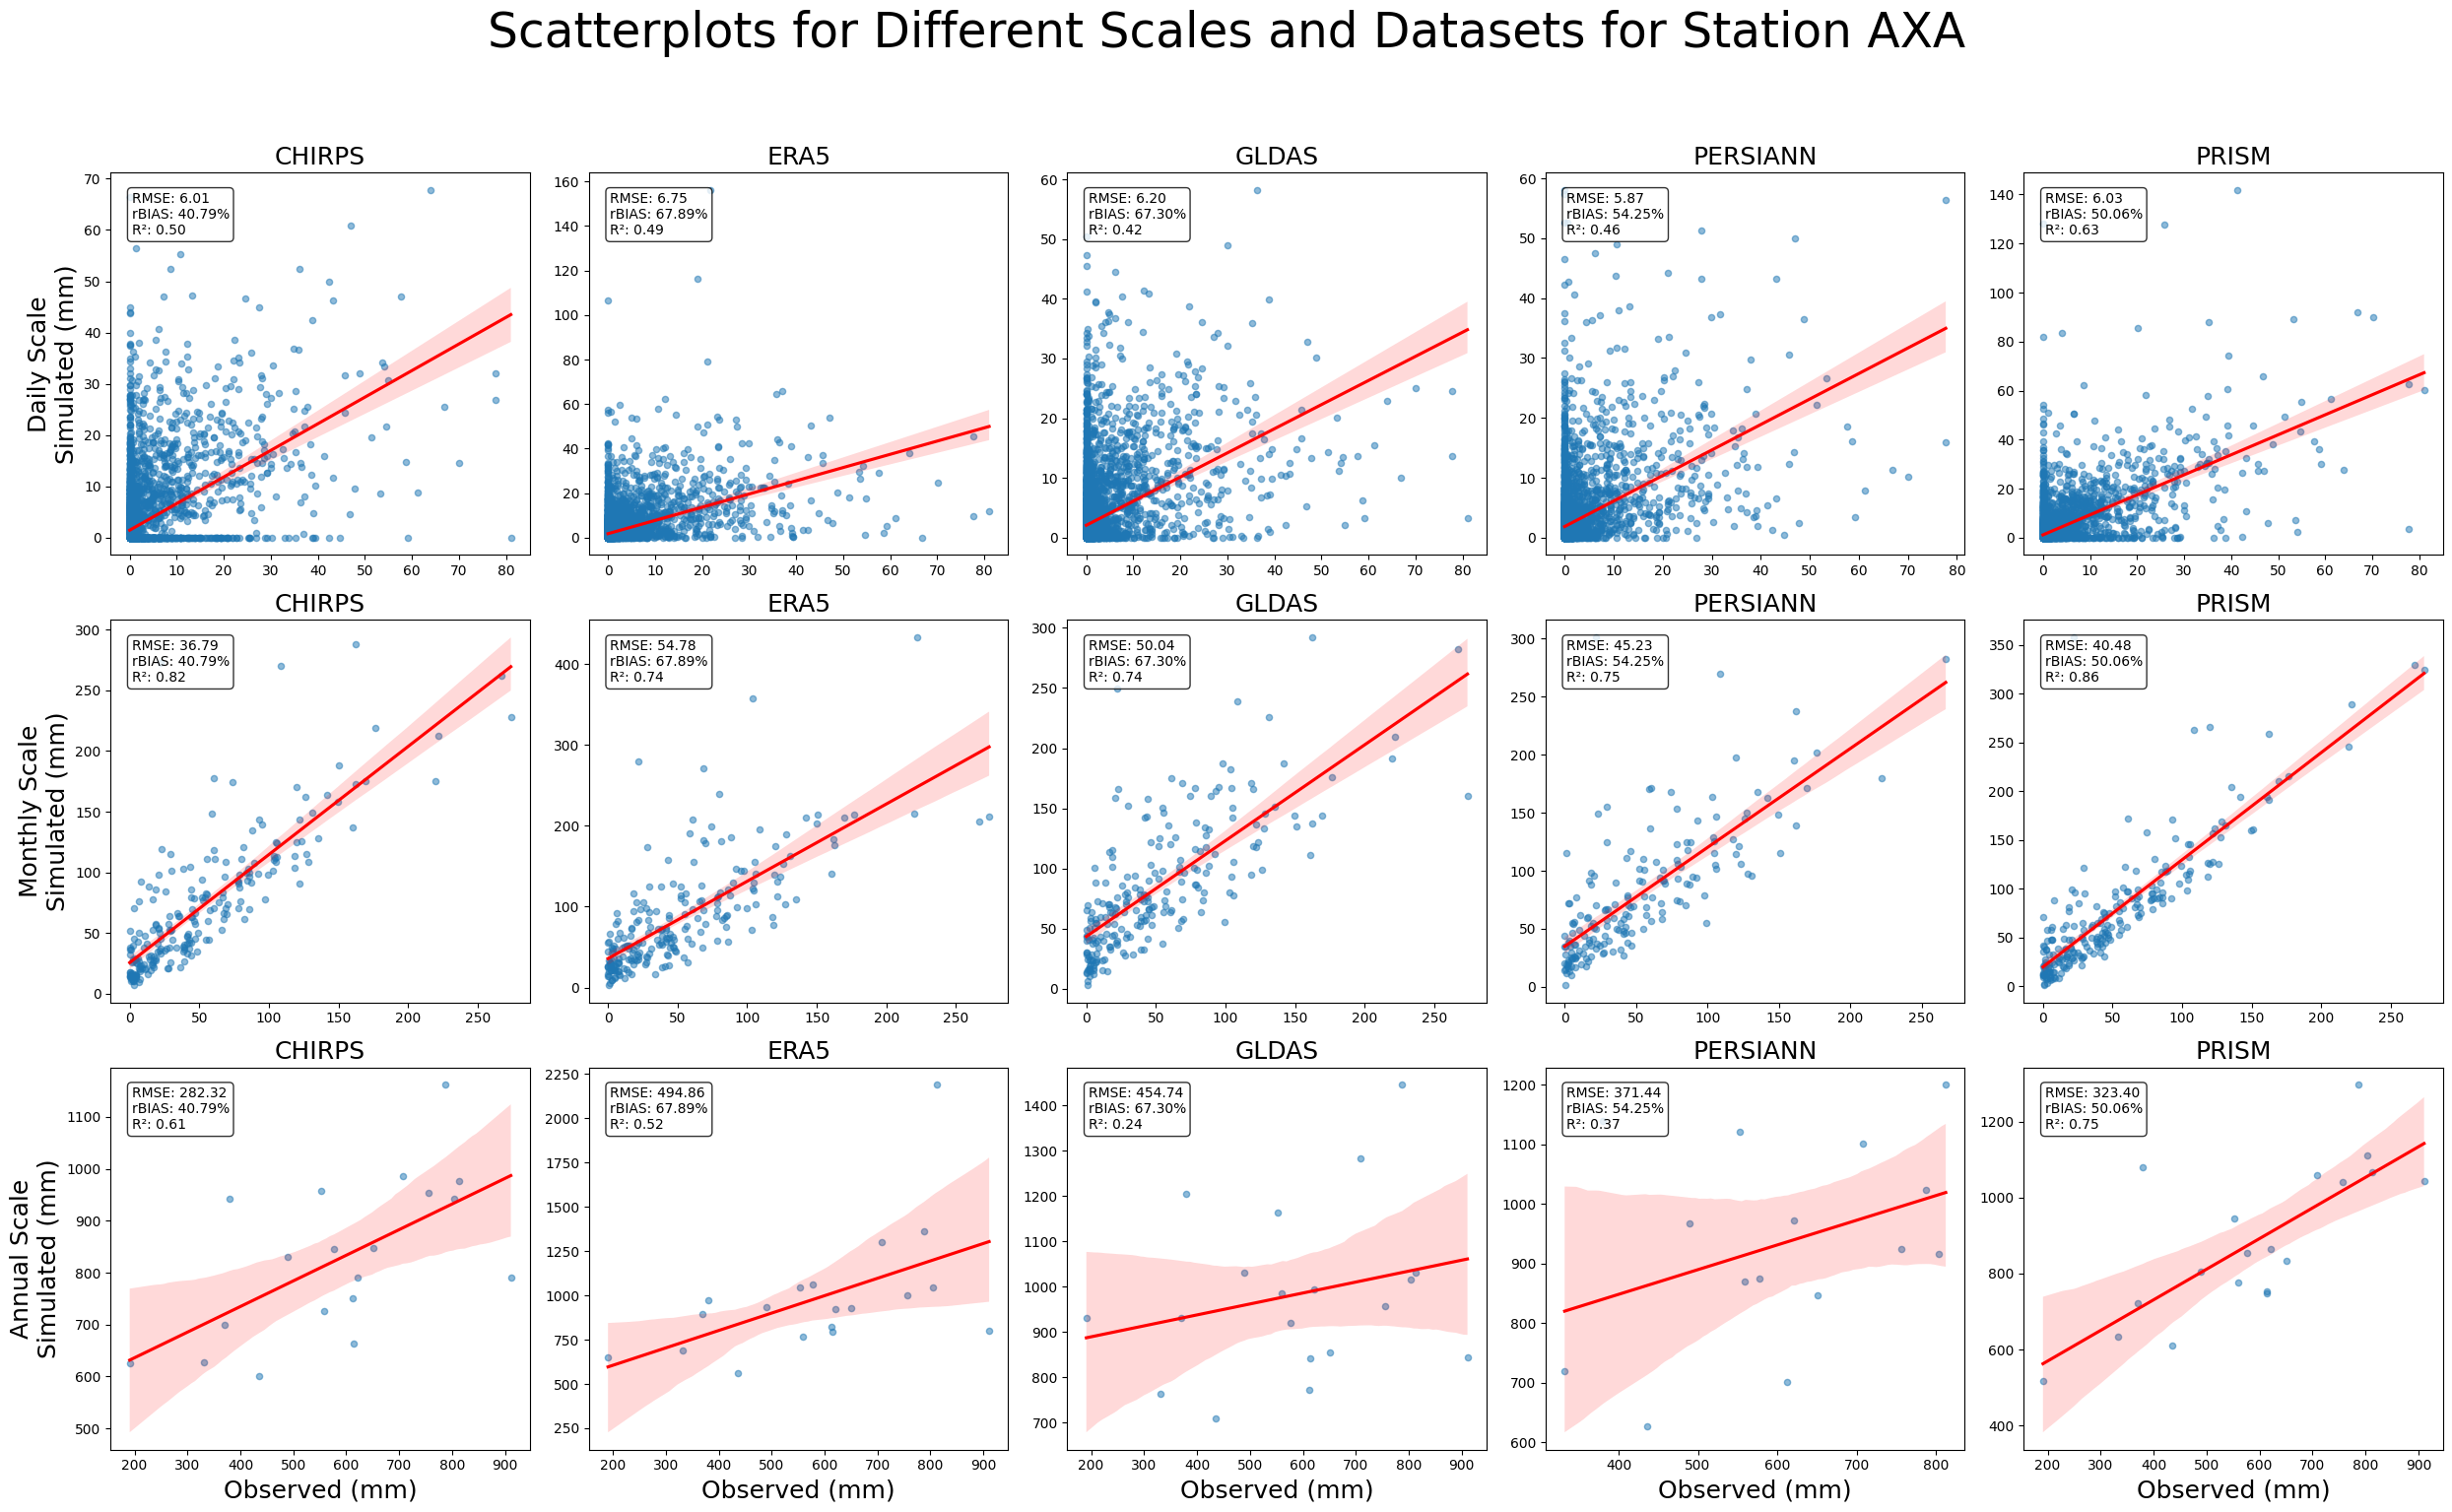

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Resample data to different temporal scales
def resample_data(data, freq, station):
    """Resample data to a specified frequency by summing rainfall."""
    resampled = data.resample(freq, on="Date")[station].sum().dropna()
    return resampled


# Define scales with updated frequency codes
scales = {
    "Daily": "D",
    "Monthly": "ME",  # Updated to 'ME' for month-end
    "Annual": "YE"    # Updated to 'YE' for year-end
}
#datasets_to_plot = ["CHIRPS", "ERA5", "GLDAS", "GPM", "GSMAP", "PERSIANN", "PRISM"]
datasets_to_plot = ["CHIRPS", "ERA5", "GLDAS", "PERSIANN", "PRISM"]
station_to_plot = "AXA"  # Specify the rain gauge station

# Create a grid for plots
fig, axes = plt.subplots(len(scales), len(datasets_to_plot), figsize=(5 * len(datasets_to_plot), 5 * len(scales)))
fig.suptitle(f"Scatterplots for Different Scales and Datasets for Station {station_to_plot}", fontsize=35, y=1.02)

# Iterate over scales (rows)
for i, (scale, freq) in enumerate(scales.items()):
    # Iterate over datasets (columns)
    for j, dataset in enumerate(datasets_to_plot):
        ax = axes[i, j]

        # Check if the dataset and station exist
        if station_to_plot in dataframes["Observed"].columns and station_to_plot in dataframes[dataset].columns:
            # Resample observed and simulated data
            observed_data = dataframes["Observed"][["Date", station_to_plot]].dropna()
            simulated_data = dataframes[dataset][["Date", station_to_plot]].dropna()

            observed_resampled = resample_data(observed_data, freq, station_to_plot)
            simulated_resampled = resample_data(simulated_data, freq, station_to_plot)

            # Align resampled data
            merged = pd.merge(
                observed_resampled.reset_index(),
                simulated_resampled.reset_index(),
                on="Date",
                suffixes=("_obs", "_sim")
            )

            if merged.empty:
                ax.text(0.5, 0.5, "No Data", fontsize=12, ha="center", va="center")
                ax.set_title(f"{dataset}", fontsize=14)
                ax.set_xlabel("")
                ax.set_ylabel("")
                continue

            observed = merged[f"{station_to_plot}_obs"]
            simulated = merged[f"{station_to_plot}_sim"]

            # Calculate metrics
            rmse = np.sqrt(mean_squared_error(observed, simulated))
            r2 = np.corrcoef(observed, simulated)[0, 1]
            bias = 100 * (simulated.sum() - observed.sum()) / observed.sum()

            # Plot scatterplot with regression line
            sns.regplot(
                x=observed,
                y=simulated,
                scatter_kws={"s": 20, "alpha": 0.5},
                line_kws={"color": "red"},
                ax=ax
            )

            # Customize the plot
            ax.set_title(f"{dataset}", fontsize=18)
            if j == 0:
                ax.set_ylabel(f"{scale} Scale\nSimulated (mm)", fontsize=18)
            else:
                ax.set_ylabel("")
            if i == len(scales) - 1:
                ax.set_xlabel("Observed (mm)", fontsize=18)
            else:
                ax.set_xlabel("")

            # Display metrics
            ax.text(
                0.05, 0.95, f"RMSE: {rmse:.2f}\nrBIAS: {bias:.2f}%\nR²: {r2:.2f}",
                fontsize=10, transform=ax.transAxes, verticalalignment="top",
                bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
            )
        else:
            ax.text(0.5, 0.5, "No Data", fontsize=12, ha="center", va="center")
            ax.set_title(f"{dataset}", fontsize=14)

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


## 9. Box Plots of Metrics Across Datasets

This cell generates box plots to visualize the variation of four metrics (`RMSE`, `MAE`, `R2`, and `rBIAS (%)`) across different datasets. The plots include:

- **X-axis**: Names of datasets (e.g., CHIRPS, PRISM, etc.).
- **Y-axis**: Metric values (`RMSE`, `MAE`, `R2`, or `rBIAS (%)`).


C:\Users\revan\AppData\Local\Temp\ipykernel_25532\3858137460.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


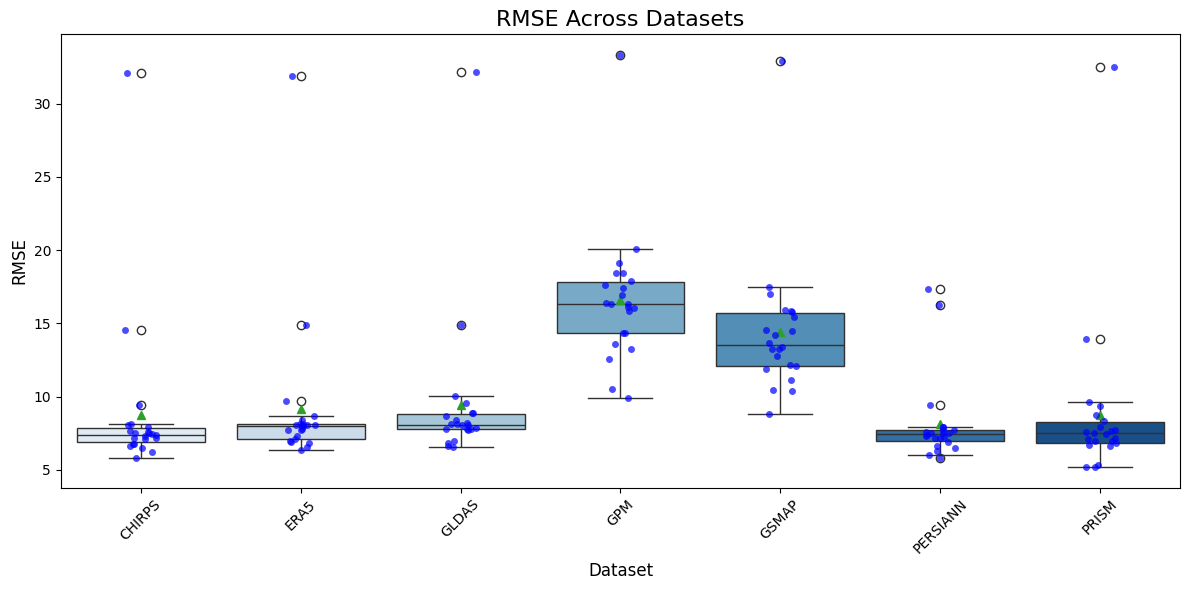

C:\Users\revan\AppData\Local\Temp\ipykernel_25532\3858137460.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


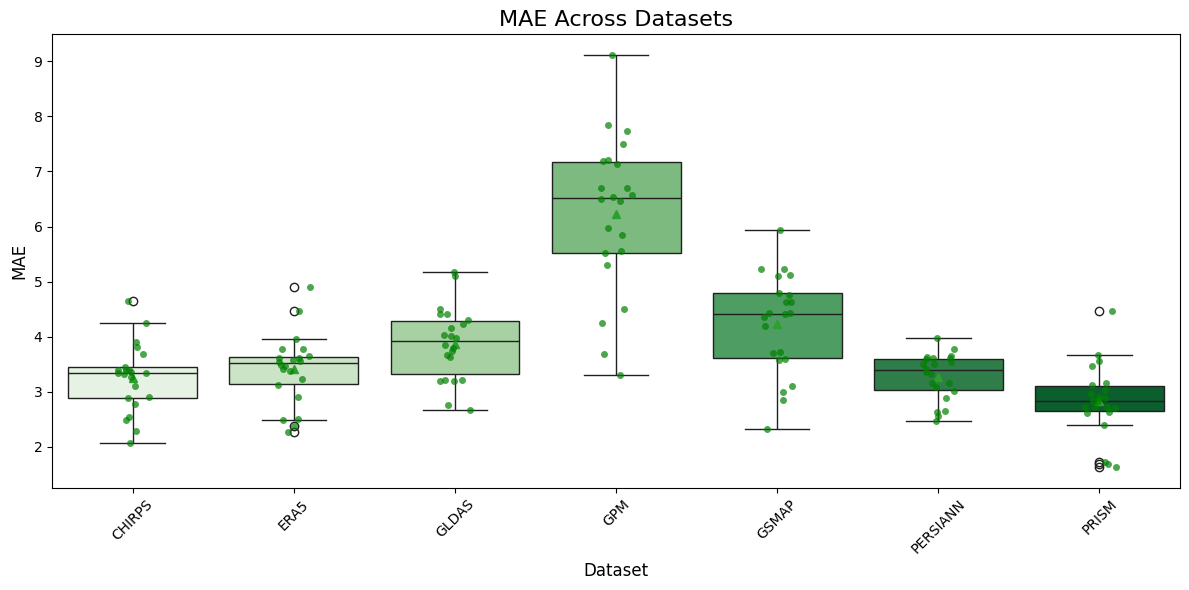

C:\Users\revan\AppData\Local\Temp\ipykernel_25532\3858137460.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


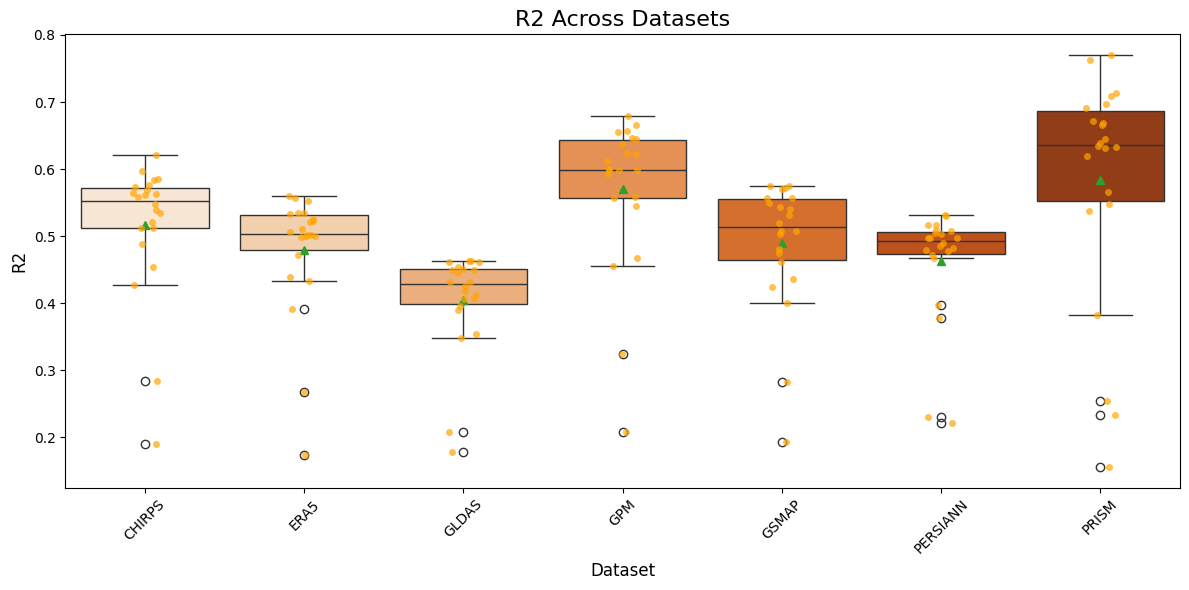

C:\Users\revan\AppData\Local\Temp\ipykernel_25532\3858137460.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


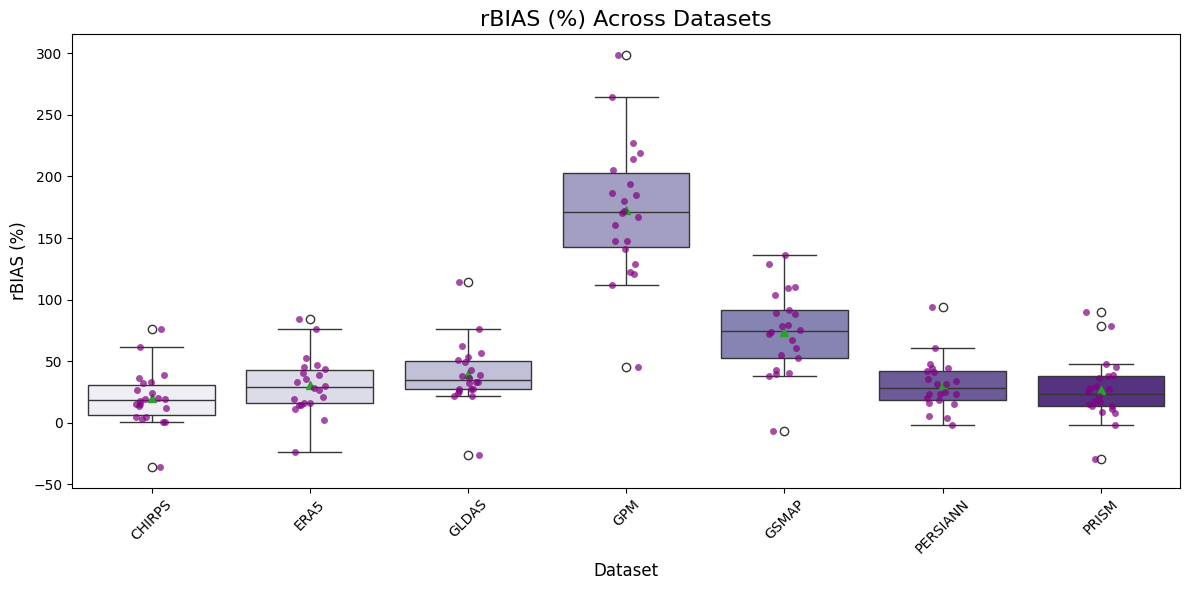

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of metrics to plot and their colors
metrics_to_plot = {
    "RMSE": {"box_color": "Blues", "point_color": "blue"},
    "MAE": {"box_color": "Greens", "point_color": "green"},
    "R2": {"box_color": "Oranges", "point_color": "orange"},
    "rBIAS (%)": {"box_color": "Purples", "point_color": "purple"}
}

# Generate box plots for each metric
for metric, colors in metrics_to_plot.items():
    plt.figure(figsize=(12, 6))
    
    # Create box plot
    sns.boxplot(
        x="Dataset",
        y=metric,
        data=metrics_df,
        showmeans=True,  # Show the mean as a line
        meanprops={"color": "red", "linestyle": "--"},  # Customize mean line
        palette=colors["box_color"]  # Set box plot color palette
    )
    
    # Overlay individual points
    sns.stripplot(
        x="Dataset",
        y=metric,
        data=metrics_df,
        color=colors["point_color"],  # Set point color
        size=5,         # Size of points
        jitter=True,    # Add jitter to separate overlapping points
        alpha=0.7       # Slight transparency for clarity
    )
    
    # Customize the plot
    plt.title(f"{metric} Across Datasets", fontsize=16)
    plt.xlabel("Dataset", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    
    # Display the plot
    plt.show()


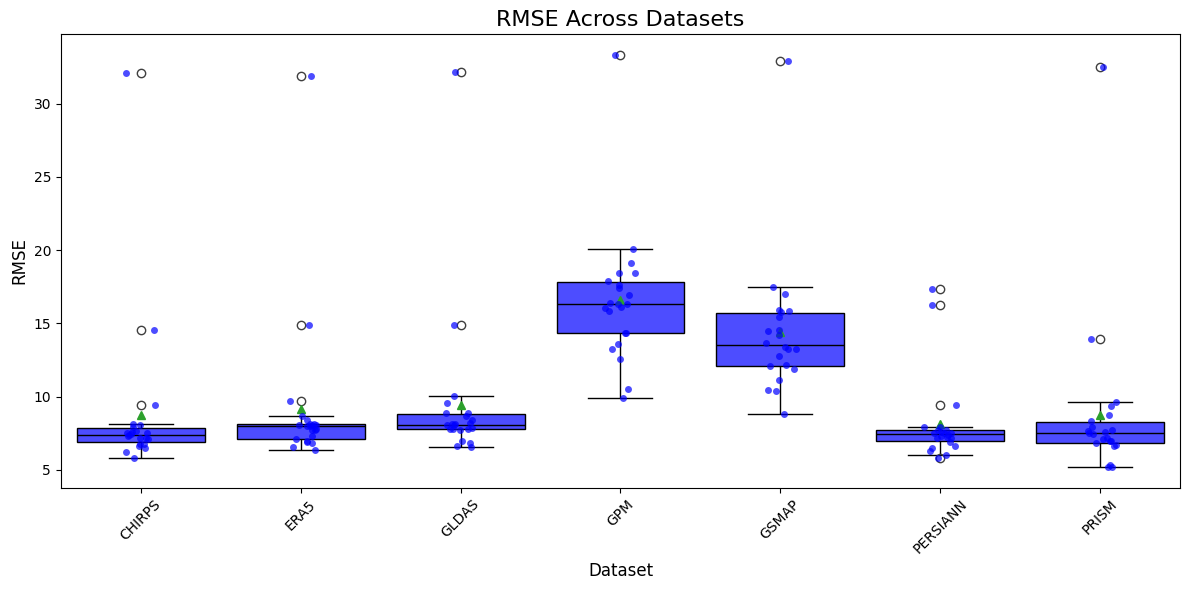

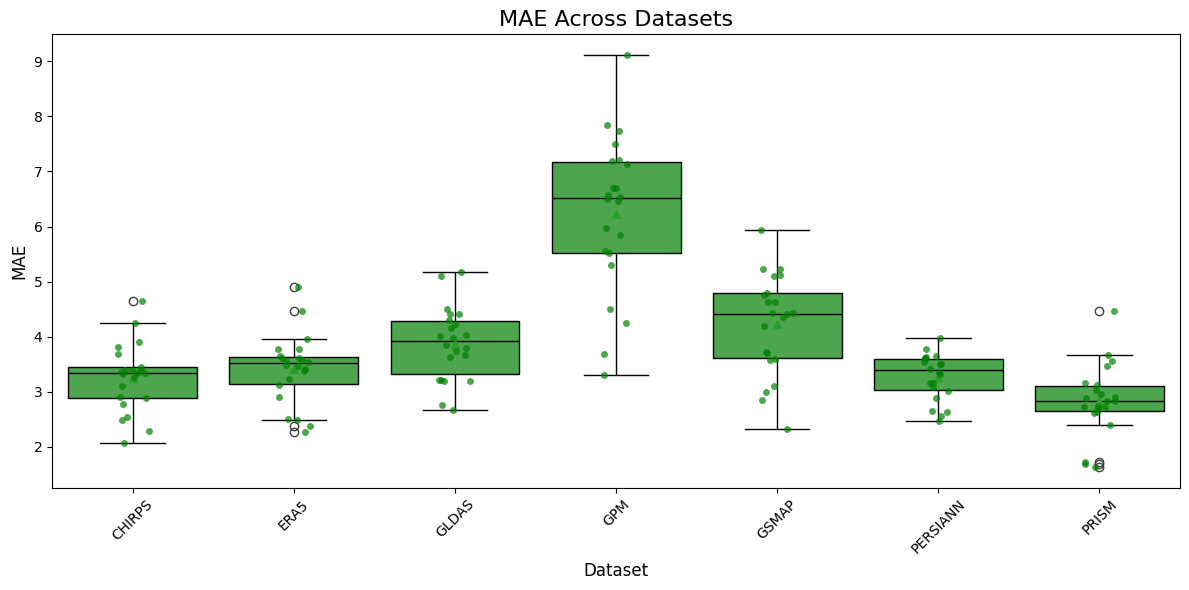

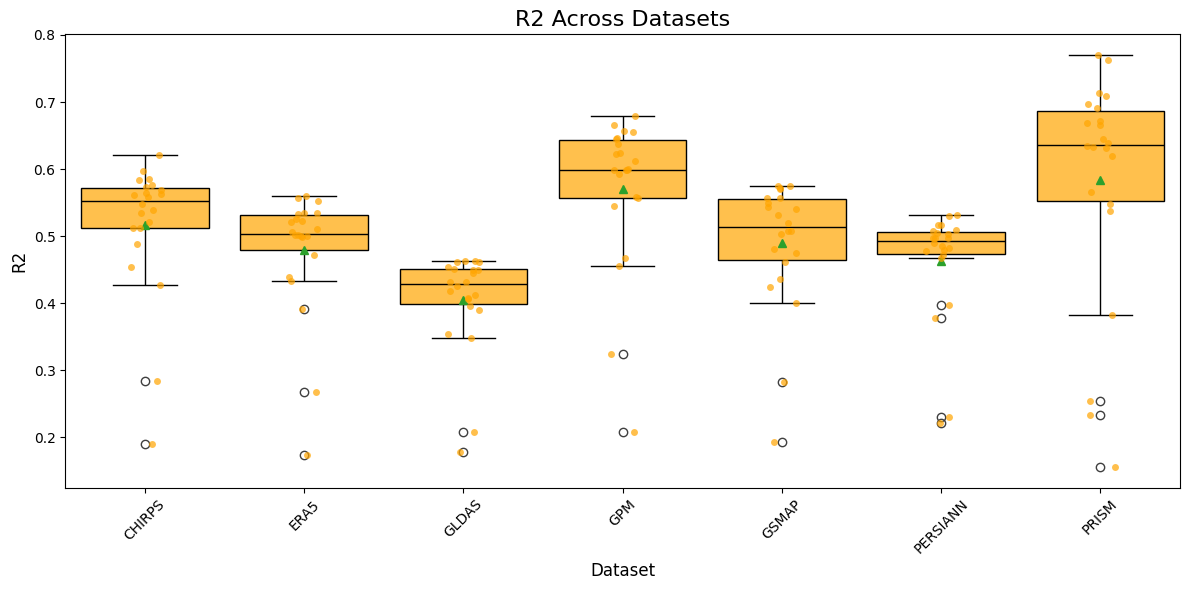

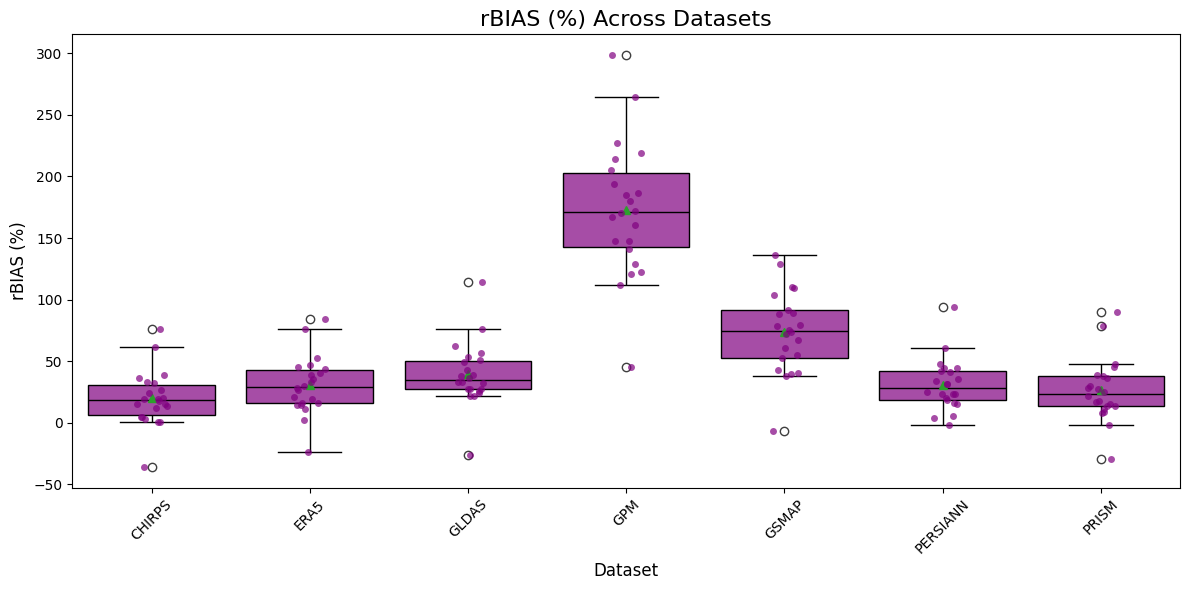

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# List of metrics to plot and their colors
metrics_to_plot = {
    "RMSE": {"color": "blue"},
    "MAE": {"color": "green"},
    "R2": {"color": "orange"},
    "rBIAS (%)": {"color": "purple"}
}

# Function to get a lighter version of a color
def lighten_color(color, amount=0.5):
    try:
        c = mcolors.cnames[color]
    except KeyError:
        c = color
    c = mcolors.to_rgb(c)
    return mcolors.to_hex([(1 - amount) + amount * x for x in c])

# Generate box plots for each metric
for metric, properties in metrics_to_plot.items():
    main_color = properties["color"]
    light_color = lighten_color(main_color, amount=0.7)
    
    plt.figure(figsize=(12, 6))
    
    # Create box plot
    sns.boxplot(
        x="Dataset",
        y=metric,
        data=metrics_df,
        showmeans=True,  # Show the mean as a line
        meanprops={"color": "red", "linestyle": "--"},  # Customize mean line
        boxprops=dict(facecolor=light_color, edgecolor="black"),  # Lighter box with black edge
        whiskerprops=dict(color="black"),  # Black whiskers
        capprops=dict(color="black"),  # Black caps
        medianprops=dict(color="black")  # Black median line
    )
    
    # Overlay individual points
    sns.stripplot(
        x="Dataset",
        y=metric,
        data=metrics_df,
        color=main_color,  # Set point color
        size=5,            # Size of points
        jitter=True,       # Add jitter to separate overlapping points
        alpha=0.7          # Slight transparency for clarity
    )
    
    # Customize the plot
    plt.title(f"{metric} Across Datasets", fontsize=16)
    plt.xlabel("Dataset", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    
    # Display the plot
    plt.show()


## 10. Heatmaps of Metrics

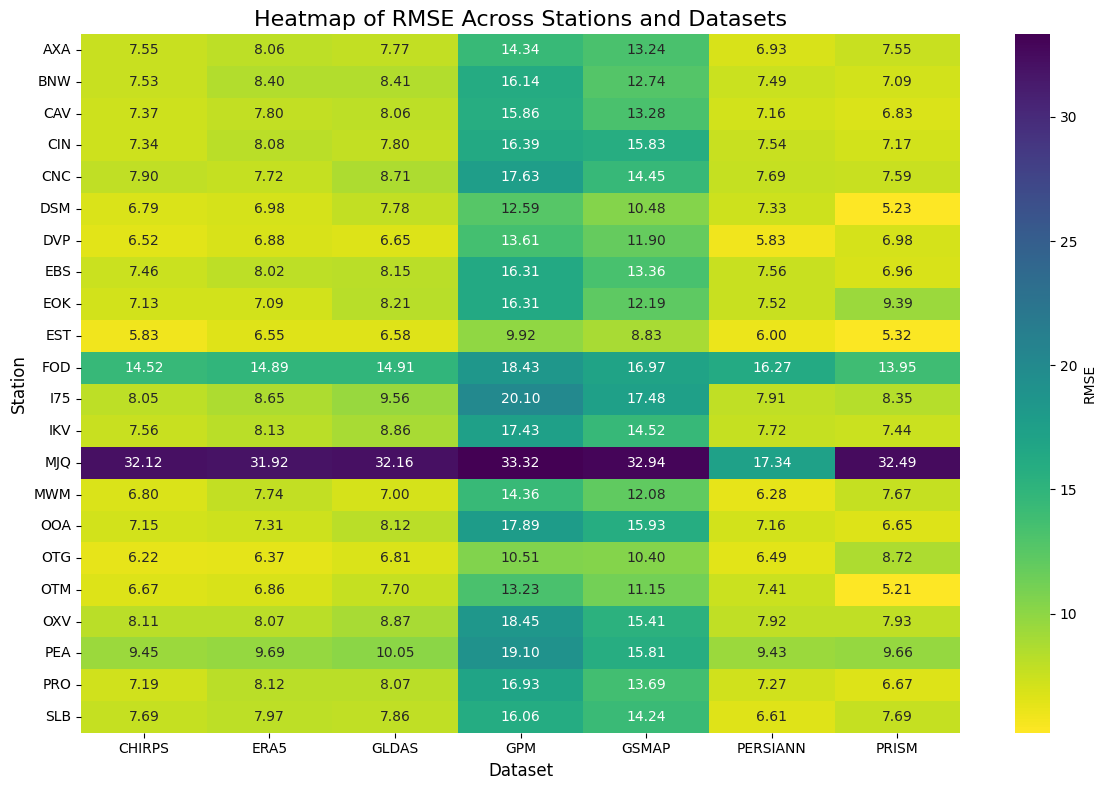

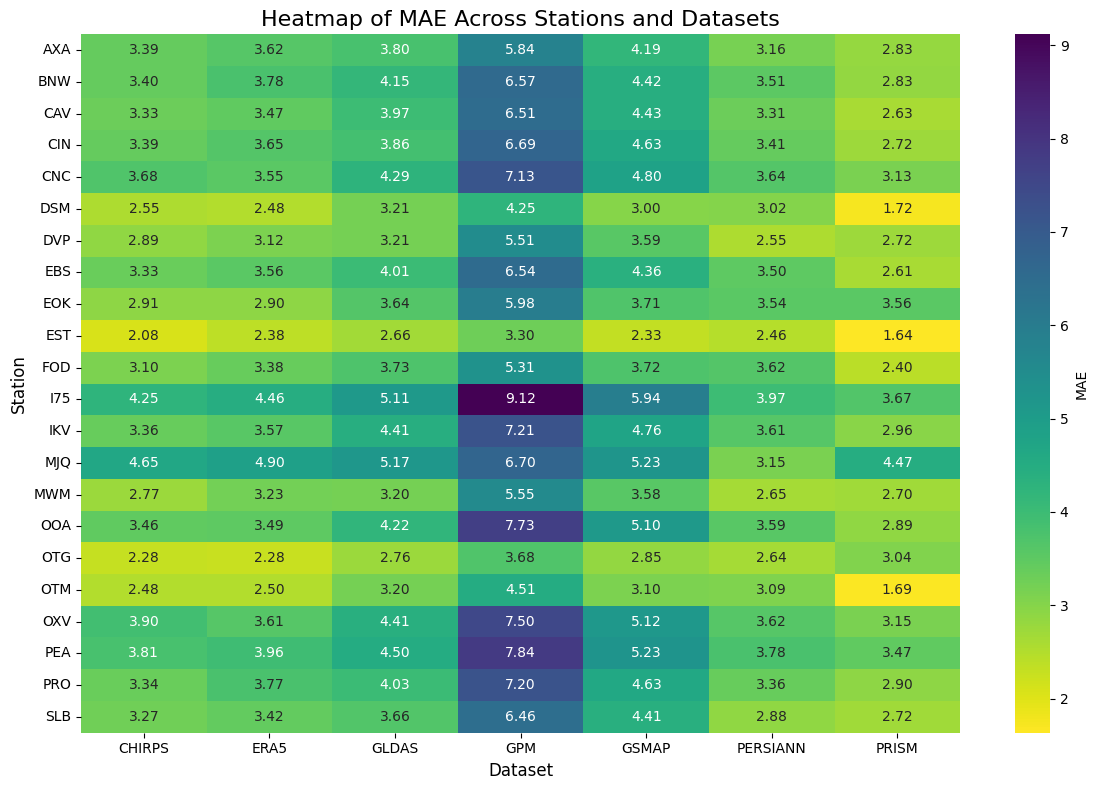

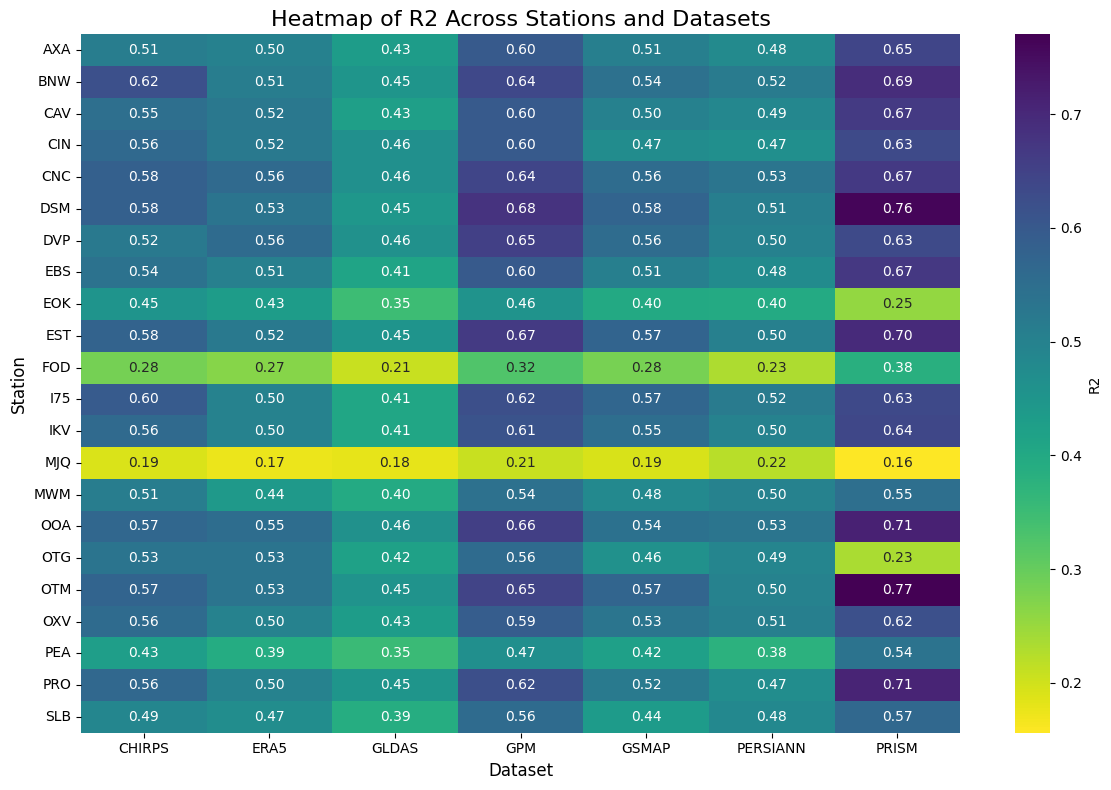

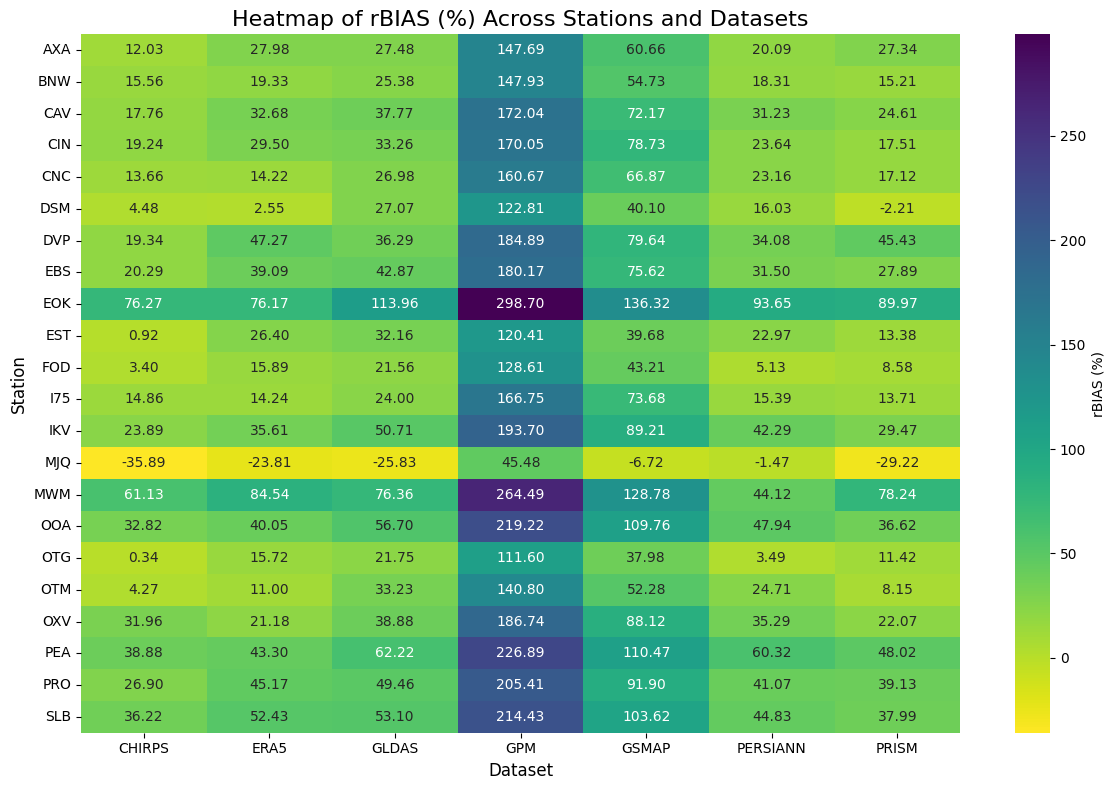

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# List of metrics to visualize
metrics_to_plot = ["RMSE", "MAE", "R2", "rBIAS (%)"]

# Create heatmaps for each metric
for metric in metrics_to_plot:
    # Pivot the DataFrame to get stations as rows and datasets as columns
    heatmap_data = metrics_df.pivot(index="Station", columns="Dataset", values=metric)
    
    # Create the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        heatmap_data,
        annot=True,  # Annotate cells with values
        fmt=".2f",   # Format numbers to 2 decimal places
        cmap="viridis_r",  # Color map
        cbar_kws={"label": metric}  # Label for the color bar
    )
    
    # Add title and labels
    plt.title(f"Heatmap of {metric} Across Stations and Datasets", fontsize=16)
    plt.xlabel("Dataset", fontsize=12)
    plt.ylabel("Station", fontsize=12)
    plt.tight_layout()
    
    # Show the plot
    plt.show()
